Running Cantera version: 2.6.0
2681.8008553986547
220.1989625172132


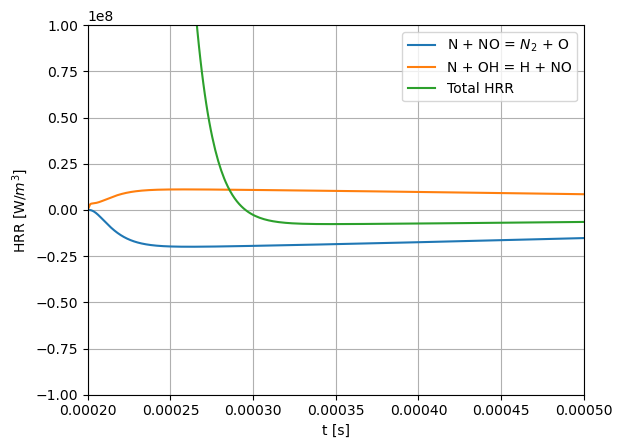

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import csv
import time
import glob
import os
import cantera as ct
print('Running Cantera version: ' + ct.__version__)

#################################These functions are used for printing output to csv files#####################################

def reaction_data_transient_batch_reactor (
        mechanism, solutiontime, reactiondata, gas_object, filename
        ):     
    datatime = {time : solutiontime}
    reactionTime = pd.DataFrame (datatime)
    for i in range(gas_object.n_reactions):
      data2 = {gas_object.reaction(i).equation : reactiondata[:,i]};
      data_to_write = pd.DataFrame(data2)
      if i == 0:
        concated_rxn_data = pd.concat([reactionTime, data_to_write], axis=1)
      else:
        concated_rxn_data = pd.concat([concated_rxn_data, data_to_write], axis=1)
      # print(gas.species_index(i))
    concated_rxn_data.to_csv('reactionData_{}_{}.csv'.format(mechanism, filename))
    
 
###############################Main function calculating ignition and HRR#######################################
def setting_up_reactor_content (equiv_ratio, 
                                reactor_pressure,
                                reactor_temperature, 
                                Fuel, 
                                Oxidizer, 
                                Diluent, 
                                Diluent_fraction):

            gas.TP = reactor_temperature, reactor_pressure          
            gas.set_equivalence_ratio(equiv_ratio, Fuel, Oxidizer, diluent=Diluent, fraction={"diluent":Diluent_fraction})
            gas_adi.TP = reactor_temperature, reactor_pressure          
            gas_adi.set_equivalence_ratio(equiv_ratio, Fuel, Oxidizer, diluent=Diluent, fraction={"diluent":Diluent_fraction})
            gas_adi.equilibrate('HP', solver='gibbs', max_steps=1000)
            adiabaticT = gas_adi.T
            print(adiabaticT)
            # gas.TPX = reactor_temperature, reactor_pressure, Fuel
            # return reactor_temperature, reactor_pressure, equiv_ratio
            return adiabaticT

def basic_idt_calculation (gas_object, filename):
    # r = ct.ConstPressureReactor(contents=gas_object, name="Batch Reactor")
    r = ct.IdealGasReactor(contents=gas_object, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])

    # use the above list to create a DataFrame
    states = ct.SolutionArray(gas_object, extra=["t","HRR"])

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimated_ignition_delay_time = 1
    t = 0

    while t < estimated_ignition_delay_time:
        t = reactor_network.step()
        states.append(r.thermo.state, t=t, HRR=gas_object.heat_release_rate)
    states.write_csv(filename)
    flameStructure = pd.read_csv(filename)
    #####################################
    reaction_data_transient_batch_reactor (
    mechanism = gas.name, 
    solutiontime = states.t,
    reactiondata = states.heat_production_rates, 
    gas_object = gas,
    filename = 'heat_production_rates')
    return flameStructure



#########################################Inputs#######################################################
mech = 'Konnov_Han2021_dup_repairedfN2.yaml'
mechname = 'Han2021'

gas = ct.Solution(mech)
gas_adi = ct.Solution(mech)
gas.name = mechname

# Simulation parameters
Pressure = 1*ct.one_atm   # pressure [Pa]
Temperature = 1000     # unburned gas temperature [K]   
phi = 1.0         # Equivalence ratio


adiabaticT = setting_up_reactor_content (equiv_ratio = phi, 
            reactor_pressure = Pressure,
            reactor_temperature = Temperature, 
            Fuel = "H2: 1.0",
            Oxidizer = "O2: 1.0, N2: 3.76, N2O: 0.0",  # Uncomment for Air
            #Oxidizer = "O2: 0.0, N2: 0.0, N2O: 1.0",  # Uncomment for N2O
            Diluent = "HE", 
            Diluent_fraction = 0.0)
                                
flameStructure = basic_idt_calculation (gas_object = gas, 
                filename = 'transient_profiles{}_{}_{}.csv'.format(gas.name,Pressure,Temperature))

saft = float(flameStructure['T'].max() - adiabaticT)
print(saft)

reactions = pd.read_csv('reactionData_Han2021_heat_production_rates.csv')
react1 = reactions['N + NO <=> N2 + O']
react2 = reactions['N + OH <=> H + NO']

data = pd.read_csv('transient_profiles{}_{}_{}.csv'.format(gas.name,Pressure,Temperature))
HRR = data['HRR']

time = flameStructure['t']

# Plot
plt.plot(time, react1, label = "N + NO = $N_{2}$ + O") 
plt.plot(time, react2, label = "N + OH = H + NO") 
plt.plot(time, HRR, label = 'Total HRR')
plt.grid(True)
plt.xlabel("t [s]")
plt.ylabel("HRR [W/$m^3$]")
pylab.xlim(0.0002, 0.0005)
pylab.ylim(-0.01e10, 0.01e10)
plt.legend() 
plt.show()